# Calculating load limits for MISO Tranche 2 transmission lines

This notebook will read two MISO graphs to calcualte three values for typical 765 kV and 345 kV transmission lines, all as a function of distance (in miles)
 - Thermal limit (MVA)
 - Safe loading limit (MW)
 - Maximum power transfer limit (MW)

Then, this will open the list of Tranch 2.1 lines from `miso_tranche2.csv`, read the length of each line, calculate the limits, and write them to the file.

The plots are on pages 39 (345 kV) and 43 (765 kV) of this [MISO presentation](https://cdn.misoenergy.org/20230308%20PAC%20Item%2007%20Discussion%20of%20765%20kV%20and%20HVDC628088.pdf).

The plots were converted into datasets using [WebPlotDigitizer](https://apps.automeris.io/wpd4/). The images, WebPlotDigitizer json files, and resulting csv files are all saved in the directory with this notebook.

## 1. Load the parameters for typical 345 and 765 kV transmission lines

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

def load_and_plot_csv(file_path, title):
    """
    Loads data from a CSV file, creates a plot of three pairs of x and y values, 
    and displays the plot. After plotting to confirm results, the function converts
    distances from miles to meters and saves the loaded CSV data into a DataFrame.

    Parameters:
    file_path (str): The path to the CSV file to load.
    title (str): The title of the plot.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the data from the CSV file.
    """
    # Load the CSV data into a pandas DataFrame
    data = pd.read_csv(file_path)
   
    # Plot each pair of x and y values with custom markers and colors
    plt.figure(figsize=(10, 6))
    
    # Plot Max, Thermal, and Safe pairs
    plt.plot(data['max-mi'], data['max-MW'], label='Max', marker='o', color='red')
    plt.plot(data['thermal-mi'], data['thermal-MW'], label='Thermal', marker='x', color='blue')
    plt.plot(data['safe-mi'], data['safe-MW'], label='Safe', marker='^', color='green')
    
    # Adding titles and labels
    plt.title(title)
    plt.xlabel('Line Miles')
    plt.ylabel('MVA or MW')
    
    # Show legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()

    # Convert the units from miles to meters and rename the columns
    mile_columns = ['max-mi', 'thermal-mi', 'safe-mi']
    for col in mile_columns:
        data[col] = data[col] * 1609.34  # Convert miles to meters
    data = data.rename(columns={         # Rename columns to meters
        'max-mi': 'max-m',
        'thermal-mi': 'thermal-m',
        'safe-mi': 'safe-m',
        'max-MW': 'max-MW',
        'thermal-MW': 'thermal-MW',
        'safe-MW': 'safe-MW'
    })
    
    # Return the DataFrame for further use if needed
    return data

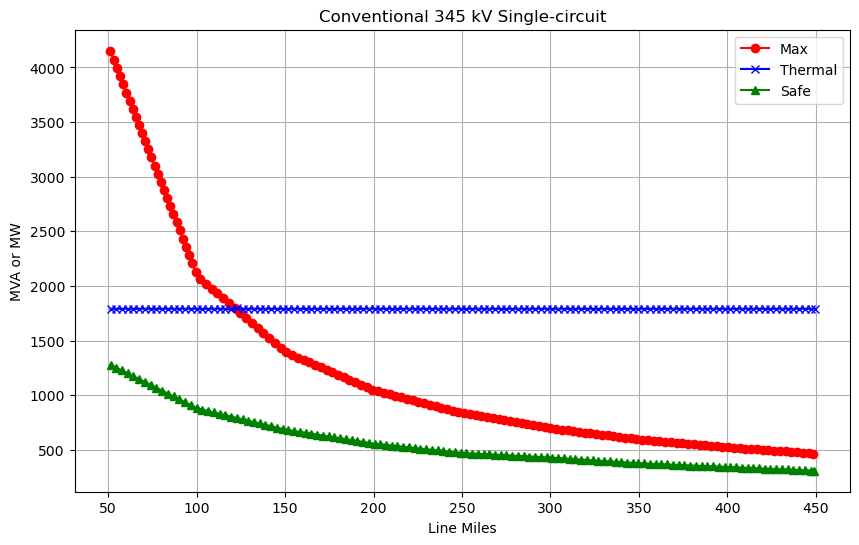

          max-m       max-MW      thermal-m   thermal-MW         safe-m  \
0  82088.841160  4152.775591   82563.458282  1791.118653   82563.458282   
1  85648.469576  4067.364507   87784.246641  1790.808756   87784.246641   
2  88496.172324  3993.505698   93005.034984  1790.808756   93005.034984   
3  91343.875056  3918.510599   98225.823342  1790.808756   98225.823342   
4  94191.577789  3844.651790  103446.611701  1790.808756  103446.611701   

       safe-MW  
0  1279.788437  
1  1253.447183  
2  1227.105930  
3  1201.074573  
4  1173.803628  


In [69]:
df_345 = load_and_plot_csv("MISO-345kV-lookup.csv","Conventional 345 kV Single-circuit")
print(df_345.head())

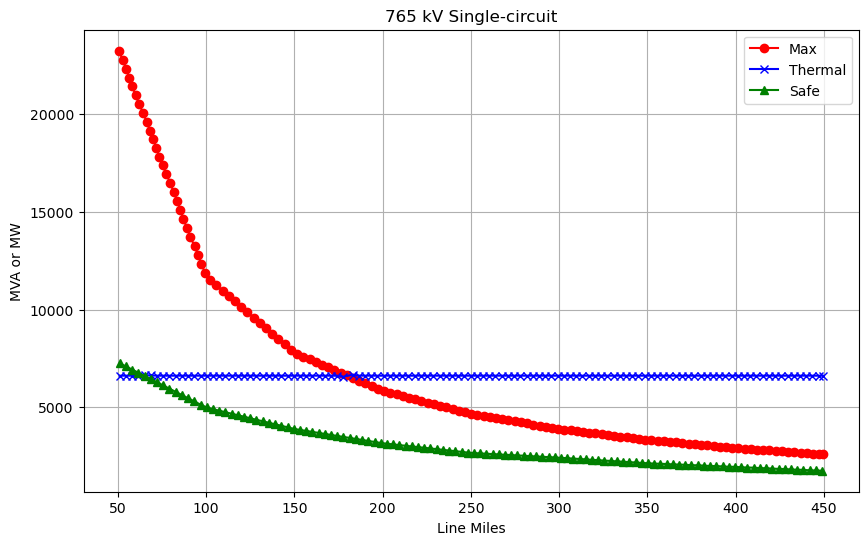

       thermal-m   thermal-MW         safe-m      safe-MW         max-m  \
0   82123.235089  6619.688805   82123.235089  7255.129821  81350.426400   
1   87790.498814  6619.688805   87790.498814  7093.255958  84956.866944   
2   93457.762523  6619.688805   93457.762523  6934.826220  88048.101700   
3   99125.026248  6592.135807   99125.026248  6767.786169  91010.535021   
4  105221.628121  6641.788606  104792.289972  6605.912306  93457.762523   

        max-MW  
0  23246.63154  
1  22758.85738  
2  22304.23291  
3  21844.87277  
4  21432.86935  


In [70]:
df_765 = load_and_plot_csv("MISO-765kV-lookup.csv","765 kV Single-circuit")
print(df_765.head())

In [71]:
# Now that we know the plots match MISO's, fix the thermal limit to the known value.
df_345['thermal-MW'] = 1793
df_765['thermal-MW'] = 6625

## 2. Load the known distances and voltages of the MISO Tranche 2.1 lines

In [72]:
df_tranche2 = pd.read_csv("miso_tranche2.csv")
df_tranche2['MW'] = np.nan
print(df_tranche2.head())

   Unnamed: 0                 r                  rr  voltage   isd  ba_r  \
0           0             Bison          Alexandria      345  2032    37   
1           1       Maple River            Riverton      345  2033    37   
2           2        Iron Range           Arrowhead      345  2032    43   
3           3   Big Stone South    Brookings County      765  2034    38   
4           4  Brookings County  Lakefield Junction      765  2034    38   

   ba_rr                                     geometry_r  \
0     43   POINT (-97.07594133595342 46.95074405068095)   
1     43   POINT (-96.87408792692817 46.91751490350292)   
2     43  POINT (-93.30363063440532 47.230351041726344)   
3     38  POINT (-96.50693878670205 45.281508125542246)   
4     68   POINT (-96.52931039032293 44.38943710056385)   

                                    geometry_rr             ll  MW  
0  POINT (-95.40566894972102 45.84743321033518)  177615.311722 NaN  
1  POINT (-94.06142288586304 46.46066878196628)  2

## 3. For each tranche 2 line, calculate the safe loading limit.

For lines shorter than 50 miles, or where the safe limit in MW exceeds the thermal limit in MVA, we assume the safe limit is the thermal limit.

In [77]:
def update_MW(row, df_lookup, max_MW):
    # Get the value from the 'll' column in df_tranche2
    ll_value = row['ll']
    # Find the closest value in the 'safe-m' column of the lookup dataframe
    closest_distance = df_lookup['safe-m'].iloc[(df_lookup['safe-m'] - ll_value).abs().argmin()]
    closest_MW = df_lookup.loc[df_lookup['safe-m'] == closest_distance, 'safe-MW'].values[0]

    # Apply the conditions and return the appropriate MW value
    if (ll_value < 50*1609.34) or closest_MW > max_MW:
        return max_MW
    else:
        return closest_MW

# Loop through df_tranche2 and apply the function
for index, row in df_tranche2.iterrows():
    if row['voltage'] == 345:
        df_tranche2.at[index, 'MW'] = update_MW(row, df_345, 1793)
    elif row['voltage'] == 765:
        df_tranche2.at[index, 'MW'] = update_MW(row, df_765, 6625)


In [78]:
print(df_tranche2.head())
df_tranche2.to_csv('miso_tranche2_limits.csv', index=False)

   Unnamed: 0                 r                  rr  voltage   isd  ba_r  \
0           0             Bison          Alexandria      345  2032    37   
1           1       Maple River            Riverton      345  2033    37   
2           2        Iron Range           Arrowhead      345  2032    43   
3           3   Big Stone South    Brookings County      765  2034    38   
4           4  Brookings County  Lakefield Junction      765  2034    38   

   ba_rr                                     geometry_r  \
0     43   POINT (-97.07594133595342 46.95074405068095)   
1     43   POINT (-96.87408792692817 46.91751490350292)   
2     43  POINT (-93.30363063440532 47.230351041726344)   
3     38  POINT (-96.50693878670205 45.281508125542246)   
4     68   POINT (-96.52931039032293 44.38943710056385)   

                                    geometry_rr             ll           MW  
0  POINT (-95.40566894972102 45.84743321033518)  177615.311722   842.523628  
1  POINT (-94.06142288586304 46.